In [22]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import json
import os
from pprint import pprint
import sys

import tensorflow as tf
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
import pyedflib

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer
from sleeprnn.nn.spectrum import compute_wavelets, apply_wavelets_rectangular
from sleeprnn.data.utils import power_spectrum

RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')

%matplotlib inline
viz.notebook_full_width()

In [2]:
# Specify what to load
ckpt_folder = '20191106_bsf_update_e1_n2_train_mass_ss/v19'
dataset_name = constants.MASS_SS_NAME
which_expert = 1
task_mode = constants.N2_RECORD
ckpt_fs = 200
seed_id_list = [0, 1, 2, 3]
set_list = [constants.TRAIN_SUBSET, constants.VAL_SUBSET, constants.TEST_SUBSET]

# Load data
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: ckpt_fs})
fs = dataset.fs
ids_dict = {
    constants.ALL_TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))
predictions_dict = reader.read_prediction_with_seeds(
    ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)
optimal_thr_list = OPTIMAL_THR_FOR_CKPT_DICT[ckpt_folder]
print('Optimal thr:', optimal_thr_list)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042
Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191106_bsf_update_e1_n2_train_mass_ss/v19/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191106_bsf_update_e1_n2_train_mass_ss/v19/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191106_bsf_update_e1_n2_train_mass_ss/v19/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20191106_bsf_update_e1_n2_train_mass_ss/v19/seed3
Optimal thr: [0.44, 0.56, 0.5, 0.48]


In [ ]:
seed_to_show = 0
set_name = 'test'
subject_id = 13
show_only_n2 = True
show_hypno = False
band_pass_freqs = [12, 14]

# -----
if dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]:
    channel_name = 'C3-CLE'
else:
    channel_name = 'F4-C4'

if show_only_n2:
    pages_subset = constants.N2_RECORD
else:
    pages_subset = constants.WN_RECORD

idx_subject = ids_dict[seed_to_show][set_name].index(subject_id)

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
if show_hypno:
    this_hypnogram = dataset.get_subject_hypnogram(subject_id=subject_id)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalization_mode=task_mode, which_expert=which_expert)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=which_expert)
if (subject_id not in [4, 8, 15, 16]) and dataset_name == constants.MASS_SS_NAME:
    this_stamps_2 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=2)
else:
    this_stamps_2 = None

event_name = dataset.event_name

this_thr = optimal_thr_list[seed_to_show]
prediction_set = predictions_dict[seed_to_show][set_name]
prediction_set.set_probability_threshold(this_thr)
this_predicted_stamps = prediction_set.get_subject_stamps(subject_id=subject_id, pages_subset=constants.WN_RECORD)
this_proba = prediction_set.get_subject_probabilities(subject_id=subject_id)

fs_real = dataset.fs
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
fs_proba = fs_real / down_factor

# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])


def filter_stamps(stamps, single_page, page_size):
    pages_list = []
    for i in range(stamps.shape[0]):
        stamp_start_page = stamps[i, 0] // page_size
        stamp_end_page = stamps[i, 1] // page_size

        start_inside = (stamp_start_page == single_page)
        end_inside = (stamp_end_page == single_page)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list


def plot_page(page_idx):

    if this_stamps_2 is None:
        fig = plt.figure(figsize=(12, 4), dpi=viz.DPI)
        gs = gridspec.GridSpec(3, 1, height_ratios=[4, 2, 1])
    else:
        fig = plt.figure(figsize=(12, 5), dpi=viz.DPI)
        gs = gridspec.GridSpec(4, 1, height_ratios=[4, 2, 1, 1])
    
    page_idx = page_idx - 1
    page_chosen = this_pages[page_idx]
    if show_hypno:
        page_state = this_hypnogram[page_of_center]
    else:
        page_state = '?'
    page_start = page_chosen * dataset.page_size
    page_end = page_start + dataset.page_size
    
    segment_signal = this_signal[page_start:page_end]
    
    segment_stamps = filter_stamps(this_stamps, page_chosen, dataset.page_size)
    if this_stamps_2 is not None:
        segment_stamps_2 = filter_stamps(this_stamps_2, page_chosen, dataset.page_size)
    segment_proba = this_proba[int(page_start/down_factor):int(page_end/down_factor)]
    segment_predicted_stamps = filter_stamps(this_predicted_stamps, page_chosen, dataset.page_size)
    
    time_axis_real = np.arange(page_start, page_end) / fs_real
    time_axis_proba = np.arange(int(page_start/down_factor), int(page_end/down_factor)) / fs_proba
    
    gs_idx = 0
    
    # Signal
    y_max = 10
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_real, segment_signal, 
        linewidth=1, color=viz.PALETTE['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=viz.PALETTE['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Subject %d (%s-%s). Page in record: %d. State %s (intervals of 0.5s are shown).' 
                 % (subject_id, dataset_name.upper(), set_name.capitalize(), page_chosen, page_state), fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Band pass Signal
    y_max = 10
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    # segment_signal_filtered = utils.narrow_filter(segment_signal, fs_real, band_pass_freqs[0], band_pass_freqs[1])
    segment_signal_filtered = utils.filter_windowed_sinusoidal(segment_signal, fs_real, 13, 41)
    ax.plot(
        time_axis_real, segment_signal_filtered, 
        linewidth=1, color=viz.PALETTE['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=viz.PALETTE['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Bandpass filtered signal (sigma)', fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Neural net
    delta_y = 0.1
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_proba, segment_proba, 
        color=viz.PALETTE['red'], linewidth=1.5, zorder=7)
    for model_stamp in segment_predicted_stamps:
        ax.fill_between(
            model_stamp / fs_real, 1+delta_y, -delta_y, 
            facecolor=viz.PALETTE['red'], zorder=6, alpha=0.3,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_xticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_yticks([0, 1])
    ax.set_yticks([this_thr], minor=True)
    ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
    ax.tick_params(labelsize=8.5)
    ax.set_title('Model prediction: probability and postprocessed stamps (%1.2f threshold is shown)' % this_thr, fontsize=10)
    
    if this_stamps_2 is not None:
        ax = fig.add_subplot(gs[gs_idx])
        # ax.imshow(segment_marks_2[np.newaxis, :], interpolation=None, aspect='auto', cmap=cmap)
        for expert_stamp in segment_stamps_2:
            ax.fill_between(
                expert_stamp / fs_real, y_max, -y_max, 
                facecolor=viz.PALETTE['blue'], alpha=0.3,
                edgecolor='k', linewidth=1.5, 
            )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim([-delta_y, 1+delta_y])
        ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
        ax.set_title('Second expert stamps (not used for training)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
widgets.interact(
    lambda page_idx: plot_page(page_idx),
    page_idx=widgets.IntSlider(min=1,max=this_pages.shape[0],step=1,value=267, continuous_update=False));

## New figs

In [3]:
# Segment of analysis with border
seed_to_show = 0
set_name = 'test'
subject_id = 13
start_time = 12600
end_time = start_time + 20
# Load data
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalize_clip=False)
this_stamps_1 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=constants.N2_RECORD, which_expert=1)
this_stamps_2 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=constants.N2_RECORD, which_expert=2)
this_thr = optimal_thr_list[seed_to_show]
prediction_set = predictions_dict[seed_to_show][set_name]
prediction_set.set_probability_threshold(this_thr)
this_predicted_stamps = prediction_set.get_subject_stamps(subject_id=subject_id, pages_subset=constants.N2_RECORD)
this_proba = prediction_set.get_subject_probabilities(subject_id=subject_id)
fs_real = dataset.fs
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
fs_proba = fs_real / down_factor
# Segment
start_sample = int(start_time*fs_real)
end_sample = int(end_time*fs_real)
segment_signal = this_signal[start_sample:end_sample]
segment_stamps_1 = utils.filter_stamps(this_stamps_1, start_sample, end_sample)
segment_stamps_2 = utils.filter_stamps(this_stamps_2, start_sample, end_sample)
segment_stamps_pred = utils.filter_stamps(this_predicted_stamps, start_sample, end_sample)
segment_proba = this_proba[int(start_time*fs_proba):int(end_time*fs_proba)]

### Figure for model scheme

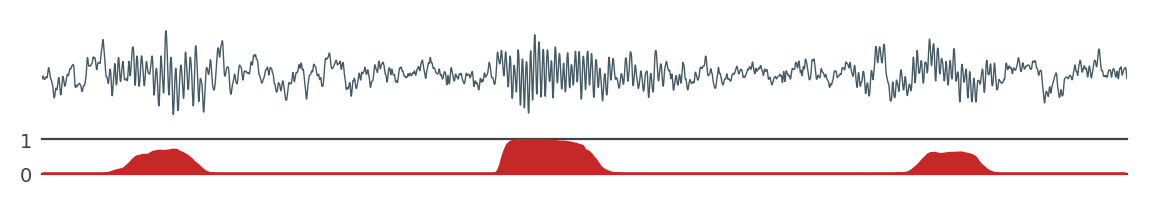

In [6]:
# Plot for model drawing
fig = plt.figure(figsize=(7, 1), dpi=viz.DPI)
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
# Signal
time_axis_real = np.arange(end_sample - start_sample) / fs_real
time_axis_proba = np.arange(int(end_time*fs_proba) - int(start_time*fs_proba)) / fs_proba

ax = fig.add_subplot(gs[0])
ax.plot(time_axis_real, segment_signal, linewidth=0.5, color=viz.PALETTE['grey'])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim([-50, 50])
ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
ax.set_xticks([])
ax.set_yticks([])
# ax.set_yticks([-50, 50])
# ax.set_yticklabels(['-50 uV', '50 uV'])
ax = plotter.set_axis_color(ax)

ax = fig.add_subplot(gs[1])
# ax.plot(time_axis_proba, segment_proba, color=viz.PALETTE['red'], linewidth=1.5, zorder=7)
ax.fill_between(time_axis_proba, segment_proba, 0, facecolor=viz.PALETTE['red'], edgecolor=viz.PALETTE['red'], zorder=5)
delta_y = 0.0
ax.set_xticks([])
ax.set_ylim([-delta_y, 1+delta_y])
ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
ax.set_yticks([0, 1])
#ax.set_yticks([this_thr], minor=True)
#ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
ax.tick_params(labelsize=7)
ax.tick_params(axis='y', which='both', length=0)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = plotter.set_axis_color(ax)
plt.show()

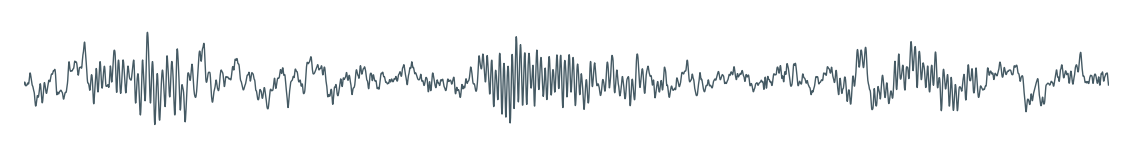

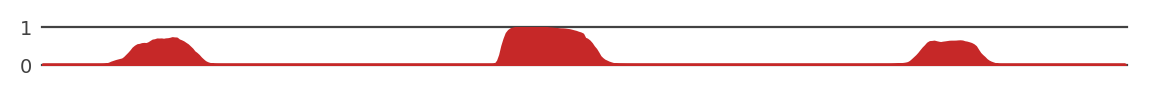

In [7]:
# Plot for model drawing
#fig = plt.figure(figsize=(7, 1), dpi=viz.DPI)
#gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
# Signal
start_sample = int(start_time*fs_real)
end_sample = int(end_time*fs_real)
time_axis_real = np.arange(end_sample - start_sample) / fs_real
time_axis_proba = np.arange(int(end_time*fs_proba) - int(start_time*fs_proba)) / fs_proba

fig, ax = plt.subplots(1, 1, figsize=(7, 0.75), dpi=viz.DPI)
ax.plot(time_axis_real, segment_signal, linewidth=0.5, color=viz.PALETTE['grey'])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylim([-50, 50])
ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
ax.set_xticks([])
ax.set_yticks([])
# ax.set_yticks([-50, 50])
# ax.set_yticklabels(['-50 uV', '50 uV'])
ax = plotter.set_axis_color(ax)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 0.25), dpi=viz.DPI)
# ax.plot(time_axis_proba, segment_proba, color=viz.PALETTE['red'], linewidth=1.5, zorder=7)
ax.fill_between(time_axis_proba, segment_proba, 0, facecolor=viz.PALETTE['red'], edgecolor=viz.PALETTE['red'], zorder=5)
delta_y = 0.0
ax.set_xticks([])
ax.set_ylim([-delta_y, 1+delta_y])
ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
ax.set_yticks([0, 1])
#ax.set_yticks([this_thr], minor=True)
#ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
ax.tick_params(labelsize=7)
ax.tick_params(axis='y', which='both', length=0)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = plotter.set_axis_color(ax)
plt.show()

### Figure for prediction visualization

In [8]:
# We need to load other channels
useful_channels = [
    'EEG F3-CLE',  # Frontal
    'EEG C3-CLE',  # Central
    'EEG O1-CLE',  # Occipital
    'EMG Chin',    # EMG
    'EOG Left Horiz',  # Left eye
    'EOG Right Horiz',  # Right eye
]
useful_channels_names = ['F3-CLE', 'C3-CLE', 'O1-CLE', 'EMG', 'EOG Left', 'EOG Right']
edf_filename = os.path.join(dataset.dataset_dir, 'register', '01-02-%04d PSG.edf' % subject_id)
signals_dict = {}
fs_from_file = 256
with pyedflib.EdfReader(edf_filename) as file:
    channel_names = file.getSignalLabels()
    print(channel_names)
    for channel in useful_channels:
        channel_to_extract = channel_names.index(channel)
        signal = file.readSignal(channel_to_extract)
        fs_old = file.samplefrequency(channel_to_extract)
        print('Channel extracted: %s with fs %s' % (file.getLabel(channel_to_extract), fs_old))
        # Particular fix for mass dataset:
        fs_old_round = int(np.round(fs_old))
        # Transform the original fs frequency with decimals to rounded version
        signal = utils.resample_signal_linear(signal, fs_old=fs_old, fs_new=fs_old_round)
        # Broand bandpass filter to signal
        if 'EEG' in channel:
            signal = utils.broad_filter(signal, fs_old_round)
        signals_dict[channel] = signal

['Resp nasal', 'EEG T4-CLE', 'EEG P3-CLE', 'EOG Left Horiz', 'EEG F4-CLE', 'EOG Right Horiz', 'ECG I', 'EEG T6-CLE', 'EEG Cz-CLE', 'EEG T5-CLE', 'EEG F7-CLE', 'EOG Upper Vertic', 'EEG T3-CLE', 'EEG C3-CLE', 'EEG Fp2-CLE', 'EEG O1-CLE', 'EEG Pz-CLE', 'EEG O2-CLE', 'EEG Fp1-CLE', 'EEG P4-CLE', 'EMG Chin', 'EEG Fpz-CLE', 'EEG F3-CLE', 'EEG C4-CLE', 'EEG A2-CLE', 'EEG F8-CLE', 'EOG Lower Vertic']
Channel extracted: EEG F3-CLE with fs 256.0163850486431
Channel extracted: EEG C3-CLE with fs 256.0163850486431
Channel extracted: EEG O1-CLE with fs 256.0163850486431
Channel extracted: EMG Chin with fs 256.0163850486431
Channel extracted: EOG Left Horiz with fs 256.0163850486431
Channel extracted: EOG Right Horiz with fs 256.0163850486431


In [23]:
# Build computational for CWT
n_scales = 32
border_size = int(5*fs_from_file)
segment_signal_file_c3 = signals_dict['EEG C3-CLE'][start_sample_file - border_size:end_sample_file + border_size]
tf.reset_default_graph()
inputs = tf.placeholder(
    dtype=tf.float32, shape=[None, segment_signal_file_c3.size], name="feats_train_ph")
wavelets, frequencies = compute_wavelets(
    fb_list=[0.5],
    fs=fs_from_file,
    lower_freq=0.5,
    upper_freq=30,
    n_scales=n_scales,
    size_factor=1.0,
    flattening=False,
    trainable=False,
    name='cmorlet')
outputs = apply_wavelets_rectangular(
    inputs=inputs,
    wavelets=wavelets,
    border_crop=border_size,
    stride=2,
    name='cwt')
sess = tf.Session()
sess.run(tf.global_variables_initializer())
results, kernels = sess.run([outputs, wavelets], feed_dict={inputs: [segment_signal_file_c3]})
results_real = results[0, ..., 0]
results_imag = results[0, ..., 1]
kernels_real = np.squeeze(kernels[0][0])
kernels_imag = np.squeeze(kernels[0][1])
cwt_magnitude = np.sqrt(results_real ** 2 + results_imag ** 2).T

# FREQ RESPONSE
kernel_size_display = int(2 * fs_from_file) + 1
wavelet_to_show_idx = n_scales // 2
wavelet_to_show_real = kernels_real[:, wavelet_to_show_idx]
wavelet_to_show_imag = kernels_imag[:, wavelet_to_show_idx]
ntaps = wavelet_to_show_real.size
max_freq = 50
min_freq = 0.1
compensation_factor_list = []
freq_axis_list = []
fft_kernel_list = []
for i in range(n_scales):
    this_kernel = kernels_real[:, i]
    max_kernel_size_to_fft = ntaps + 2000
    kernel_base = np.zeros(max_kernel_size_to_fft)
    half_sample = kernel_base.size // 2
    kernel_full = kernel_base.copy()
    kernel_half_size = this_kernel.size // 2
    start_kernel = half_sample - kernel_half_size
    end_kernel = half_sample + kernel_half_size + 1
    kernel_full[start_kernel:end_kernel] = this_kernel
    fft_kernel, freq_axis = power_spectrum(kernel_full, fs)
    compensation_factor = 1 / fft_kernel.max()
    compensation_factor_list.append(compensation_factor)
    
results_real_compensated = results_real * np.reshape(compensation_factor_list, [1, n_scales])
results_imag_compensated = results_imag * np.reshape(compensation_factor_list, [1, n_scales])
cwt_magnitude_compensated = np.sqrt(results_real_compensated ** 2 + results_imag_compensated ** 2).T
print('Done')

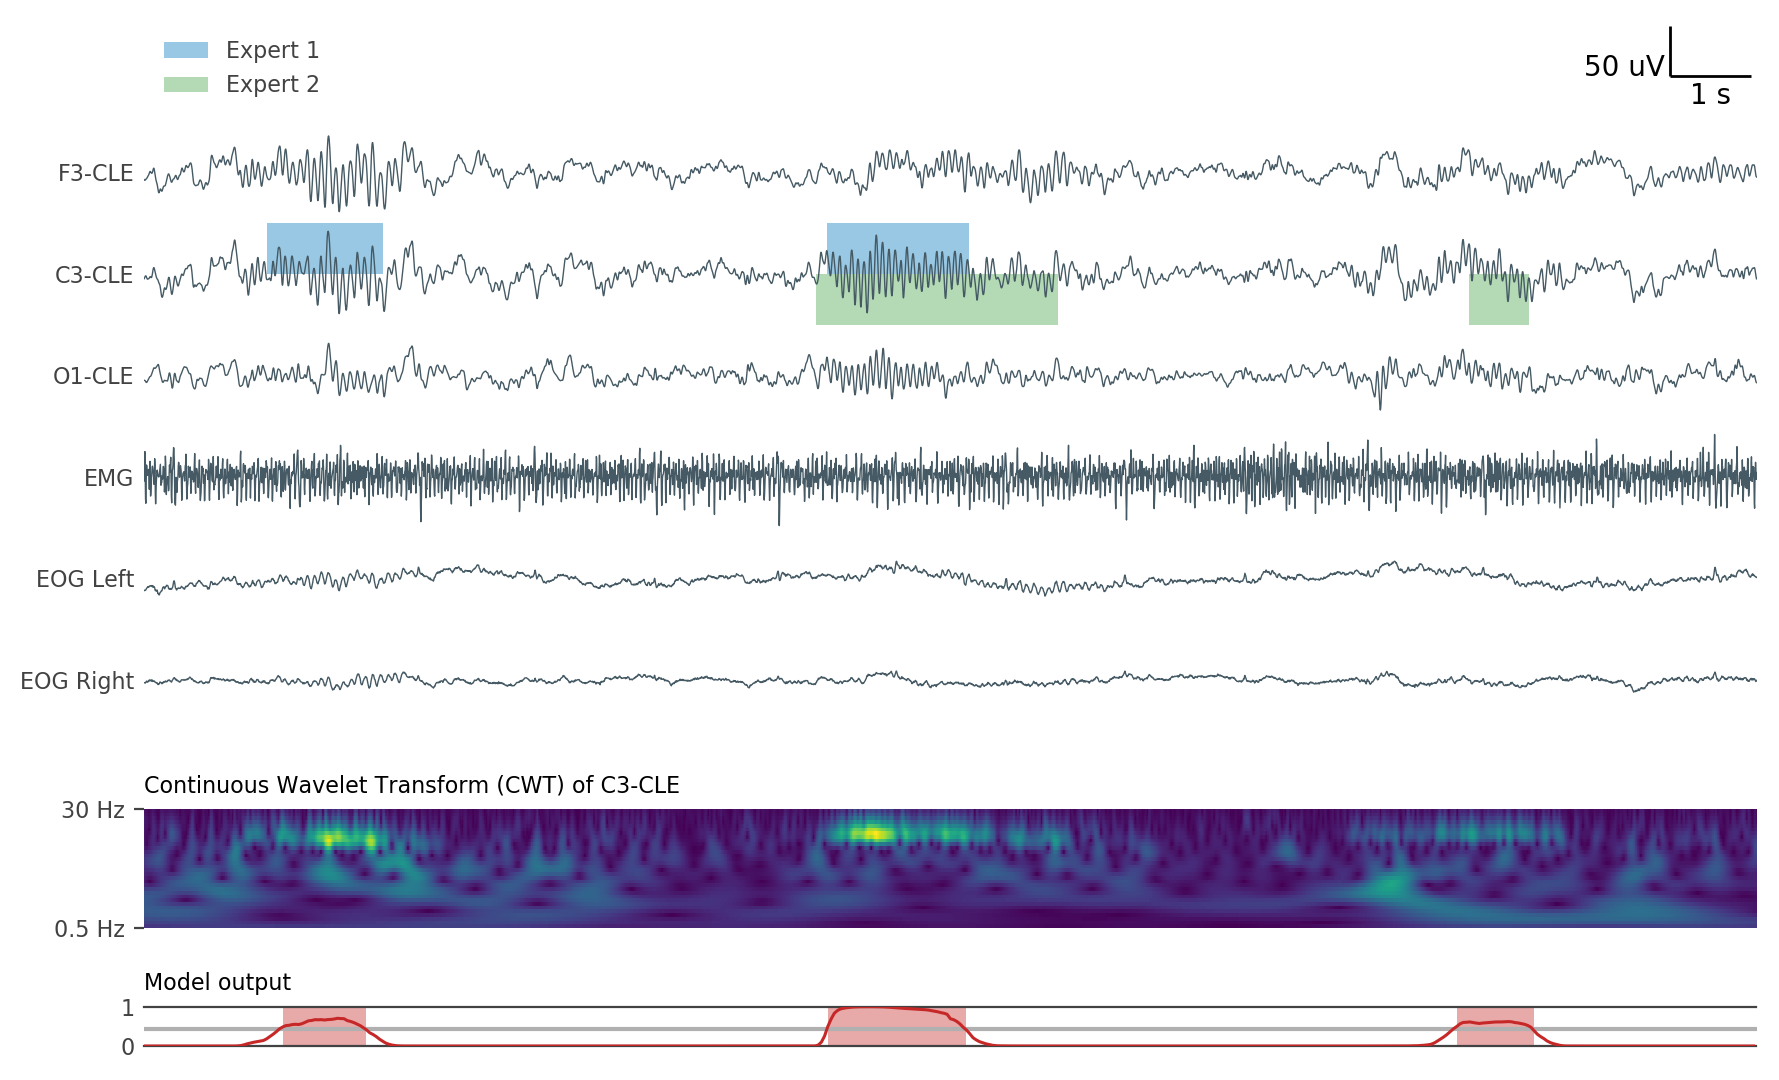

In [55]:
dpi = 200
alpha = 0.4

start_sample_file = int(start_time * fs_from_file)
end_sample_file = int(end_time * fs_from_file)
time_axis_real = np.arange(end_sample_file - start_sample_file) / fs_from_file

fig, axes = plt.subplots(
    nrows=3, ncols=1, sharex=True, 
    gridspec_kw={'height_ratios': [18, 3, 1]}, figsize=(9, 22*0.25), dpi=dpi)

ax = axes[0]
sep_signals = 100

this_center = 0
centers_list = []
for channel in useful_channels:
    this_center = this_center - sep_signals
    centers_list.append(this_center)
    segment_signal_file = signals_dict[channel][start_sample_file:end_sample_file]
    ax.plot(time_axis_real, this_center + segment_signal_file, linewidth=0.5, color=viz.PALETTE['grey'])
    if channel == 'EEG C3-CLE':
        label_shown = False
        for stamp in segment_stamps_1:
            if label_shown:
                label = None
            else:
                label = 'Expert 1'
                label_shown = True
            stamp_rel = stamp / fs_real - start_time
            ax.fill_between(
                stamp_rel, this_center + sep_signals/2, this_center, 
                facecolor=viz.PALETTE['blue'], alpha=alpha, label=label)
        label_shown = False
        for stamp in segment_stamps_2:
            if label_shown:
                label = None
            else:
                label = 'Expert 2'
                label_shown = True
            stamp_rel = stamp / fs_real - start_time
            ax.fill_between(
                stamp_rel, this_center - sep_signals/2, this_center, 
                facecolor=viz.PALETTE['green'], alpha=alpha, label=label)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
ax.set_xticks([])
ax.set_yticks([])
plotter.add_scalebar(
    ax, matchx=False, matchy=False, hidex=False, hidey=False, sizex=1, sizey=50, 
    labelx='1 s', labely='50 uV', loc=1)
ax.set_ylim([centers_list[-1] - sep_signals/2, centers_list[0] + 1.5*sep_signals])
ax.set_yticks(centers_list)
ax.set_yticklabels(useful_channels_names)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.tick_params(axis='y', which='both', length=0)
lg = ax.legend(loc='upper left', fontsize=viz.FONTSIZE_GENERAL, frameon=False)
ax = plotter.set_axis_color(ax)
lg = plotter.set_legend_color(lg)

# CWT
ax = axes[1]
ax.set_title('Continuous Wavelet Transform (CWT) of C3-CLE', fontsize=viz.FONTSIZE_GENERAL, loc='left')
ax.imshow(
    cwt_magnitude_compensated, interpolation='none', #aspect='auto', 
    extent=[time_axis_real[0], time_axis_real[-1], 0.5, 30], aspect='auto')
ax.set_xticks([])
ax.set_yticks([0.5, 30])
ax.set_yticklabels(['0.5 Hz', '30 Hz'])
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax = plotter.set_axis_color(ax)

# Output
ax = axes[2]
ax.plot(time_axis_proba, segment_proba, color=viz.PALETTE['red'], linewidth=1.1, zorder=7)

for stamp in segment_stamps_pred:
    stamp_rel = stamp / fs_real - start_time
    ax.fill_between(
        stamp_rel, 0, 1, 
        facecolor=viz.PALETTE['red'], alpha=alpha)
delta_y = 0
ax.set_xticks([])
ax.set_ylim([-delta_y, 1+delta_y])
ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
ax.set_yticks([0, 1])
ax.set_yticks([this_thr], minor=True)
ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
ax.tick_params(labelsize=viz.FONTSIZE_GENERAL)
ax.tick_params(axis='y', which='both', length=0)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Model output', fontsize=viz.FONTSIZE_GENERAL, loc='left')
ax = plotter.set_axis_color(ax)

plt.tight_layout()
plt.show()